In [60]:
import os
from pathlib import Path
from tqdm import tqdm
import pyaudio
import wave
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import librosa
import IPython.display as ipd
import librosa.display

from pathlib import Path

from threading import Thread

In [61]:
ROOT = os.path.join(os.getcwd())
DDIR = os.path.join(os.getcwd(), 'dataset')
CHUNK = 1024
FORMAT = pyaudio.paInt16
CHANNELS = 1
RATE = 44100
all_type = ['maju','belok_kiri','belok_kanan','serong_kiri','serong_kanan','stop','putar_balik_kiri', 'putar_balik_kanan', 'other']

In [62]:
def save_dataframe(df:pd.DataFrame, name:str):
    if not os.path.exists('excel'):
        os.makedirs('excel')
    df.to_excel(f'{os.path.join(ROOT, "excel", name)}.xlsx', index=False)
    return print(f'Saved as {name}.xlsx')

In [63]:
def many_files():
    total_files:int = 0
    total_directories:int = 0
    for x in os.listdir(DDIR):
        # print(x)
        print(f'{x}: {len(os.listdir(os.path.join(DDIR, x)))}')
        total_files += len(os.listdir(os.path.join(DDIR, x)))
        total_directories+=1
    print('-=====================-')
    print(f'Total files: {total_files}')
    print(f'Total directories: {total_directories}')

In [64]:
many_files()

belok_kanan: 70
belok_kiri: 72
maju: 121
other: 226
putar_balik_kanan: 40
putar_balik_kiri: 40
serong_kanan: 70
serong_kiri: 70
stop: 70
-=====================-
Total files: 779
Total directories: 9


In [65]:
from pydub import AudioSegment as am
for x in tqdm(os.listdir(DDIR)):
    for y in os.listdir(os.path.join(DDIR, x)):
        if y.endswith('.wav'):
            sound = am.from_wav(os.path.join(DDIR, x, y))
            sound = sound.set_channels(1)
            sound.export(os.path.join(DDIR, x, y), format='wav')

100%|██████████| 9/9 [00:01<00:00,  8.18it/s]


In [66]:
def mfcc(audio_obj:str=None, frame_rate:int=2048, hop_len:int=512, mfcc_num:int=100, visualize:bool=True):
    signal, sr = librosa.load(audio_obj)
    mfcc_spectrum = librosa.feature.mfcc(y=signal, sr=sr, n_fft=frame_rate, hop_length=hop_len, n_mfcc=mfcc_num)
    # delta_1_mfcc = librosa.feature.delta(mfcc_spectrum, order=1)
    # delta_2_mfcc = librosa.feature.delta(mfcc_spectrum, order=2)

    mfcc_features = np.mean(mfcc_spectrum, axis=1)

    if visualize:
        plt.figure(figsize=(14, 15))
        plt.subplot(3, 1, 1)
        librosa.display.specshow(mfcc_spectrum, sr=sr, hop_length=hop_len, x_axis='time')
        plt.colorbar(format='%+2.0f dB')
        plt.title(f'MFCC of {audio_obj}')

        plt.subplot(3, 1, 2)
        librosa.display.specshow(delta_1_mfcc, sr=sr, hop_length=hop_len, x_axis='time')
        plt.colorbar(format='%+2.0f dB')
        plt.title(f'MFCC Delta 1 of {audio_obj}')

        plt.subplot(3, 1, 3)
        librosa.display.specshow(delta_2_mfcc, sr=sr, hop_length=hop_len, x_axis='time')
        plt.colorbar(format='%+2.0f dB')
        plt.title(f'MFCC Delta 2 of {audio_obj}')

        plt.tight_layout()
        plt.show()
    return mfcc_features

In [67]:
# test_input = os.path.join(DDIR, 'maju', 'maju_1.wav')
# audio_obj = ipd.Audio(test_input)
# audio, sr = librosa.load(test_input)

# librosa.display.waveshow(audio , sr=sr)
# plt.title(f'Audio Waveform of {test_input}')
# plt.show()

In [68]:
def audio_features(path:os.PathLike=DDIR, frame_size:int=2048, hop_len:int=512, mfcc_num:int=100):
    audio_files = os.listdir(path)
    list_df = []
    # print(audio_files)
    for audio_name in tqdm(audio_files):
        audios_mfcc,audios_label = [],[]
        for audio in glob.glob(f'{os.path.join(DDIR , audio_name)}/*.wav'):
            mfcc_score = mfcc(audio_obj=audio, frame_rate=frame_size, hop_len=hop_len, mfcc_num=mfcc_num, visualize=False)
        # mfcc_score = mfcc(audio_obj=f'{os.path.join(path, audio_name)}', frame_rate=frame_size, hop_len=hop_len, mfcc_num=mfcc_num, visualize=False)
        
            audios_mfcc.append(mfcc_score)
            if(audio_name != 'other'):
                label = audio.split('\\')[-1].split('_')
                label = '_'.join(label[:len(label)-1])
            else:
                label = 'other'
            audios_label.append(label)

    # print(len(audios_mfcc), len(audios_zcr), len(audios_rmse), len(audios_label))
    # print(audios_mfcc[0].shape, audios_zcr[0].shape, audios_rmse[0].shape)
        audio_features = np.column_stack(audios_mfcc)
        # print(audio_features.shape)
        df = pd.DataFrame(audio_features)
        df = df.T
        # df.insert(loc=0, column='name', value=audio_label)
        df['label'] = audios_label

        list_df.append(df)
    return list_df

In [69]:
belok_kanan, belok_kiri, maju, other, putar_balik_kanan, putar_balik_kiri, serong_kanan, serong_kiri, stop = audio_features(path=DDIR, frame_size=2048, hop_len=512, mfcc_num=100)

100%|██████████| 9/9 [00:06<00:00,  1.37it/s]


In [70]:
# belok_kanan_df = audio_features(path=os.path.join(DDIR, 'belok_kanan'), frame_size=2048, hop_len=512, mfcc_num=100)

In [71]:
serong_kanan

,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,label
0,-380.074615,58.260147,-0.587196,9.357736,3.998401,3.897801,0.967041,-2.311783,1.511695,4.123258,...,0.103644,0.277166,0.268819,0.011929,0.294096,0.106548,-0.174768,-0.238971,-0.150358,serong_kanan
1,-400.412933,81.056763,1.259394,11.193357,3.868623,-0.593123,2.365073,-0.667273,3.388696,3.677302,...,-0.481262,-0.267577,0.052987,-0.393829,-0.085509,0.070544,-0.349475,-0.379528,-0.013909,serong_kanan
2,-428.661133,57.479919,-3.349911,10.057857,2.756717,2.204338,3.409310,-0.366781,1.402641,1.862988,...,-0.279529,-0.560101,-0.333088,-0.392702,-0.421262,-0.210110,-0.244184,-0.572543,-0.379502,serong_kanan
3,-453.865479,56.457405,-4.492160,15.571338,7.973554,3.145535,5.847776,1.554070,3.103191,3.556479,...,-0.152805,-0.324230,-0.354708,-0.294237,-0.078342,-0.366582,-0.499392,-0.364386,0.106265,serong_kanan
4,-429.726074,53.000835,3.172668,13.910784,6.190843,5.544556,5.674410,2.104498,2.150882,3.181381,...,-0.371757,0.021584,-0.126865,-0.640334,-0.314716,-0.272022,-0.275173,-0.512959,-0.020131,serong_kanan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,-413.330048,91.826759,-13.520096,12.449458,-6.344860,-3.899706,-10.751988,-6.284375,-3.352993,-1.283983,...,0.772176,-0.397521,-0.013804,-0.016437,0.170985,-0.719831,0.314722,-0.195510,0.333085,serong_kanan
66,-459.121399,66.951698,-8.877245,6.516498,5.150327,1.190079,4.391885,-2.318023,0.781615,4.962187,...,-0.297946,-0.326064,-0.167865,-0.765484,-0.504372,-0.348878,-0.275341,-0.667133,-0.536790,serong_kanan
67,-398.608765,83.548889,-8.661835,9.612595,-8.487599,-2.952939,-9.160398,-5.155799,-0.947111,-3.292830,...,0.119287,-0.450644,-0.487116,-0.218017,0.770610,-0.383795,0.611041,-0.324078,0.636435,serong_kanan
68,-367.660431,96.229057,-6.241835,10.018987,3.433935,-5.628638,-3.239011,-3.085521,2.122401,0.175545,...,0.123640,-0.444557,-0.042744,-0.506295,0.096704,-0.319243,-0.745191,-0.960637,0.087991,serong_kanan


In [72]:
df = pd.concat([belok_kanan, belok_kiri, maju, other, putar_balik_kanan, putar_balik_kiri, serong_kanan, serong_kiri, stop], ignore_index=True)

In [73]:
df

,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,label
0,-422.895020,48.039368,-6.186774,5.216863,0.528688,0.511103,0.804288,-2.947132,-1.912176,-1.176030,...,0.210378,-0.140555,0.035365,0.327993,0.097341,-0.261531,-0.144780,-0.032475,-0.001613,belok_kanan
1,-452.015533,75.630280,3.107103,13.786242,10.602611,5.711093,9.261926,1.144305,-0.127123,4.809555,...,-0.385292,-0.396922,-0.195165,-0.274765,-0.303379,-0.565148,-0.229500,-0.267201,-0.383995,belok_kanan
2,-451.404572,79.344475,6.550086,13.724059,8.741273,5.700652,10.009722,4.446376,1.270512,4.347304,...,-0.593732,-0.846818,-0.305814,-0.309355,-0.451223,-0.471889,-0.150527,-0.357839,-0.259098,belok_kanan
3,-427.350311,74.012665,7.923713,17.727348,10.162389,3.991512,8.650618,0.311897,-0.763944,3.620642,...,-0.425157,-0.406701,-0.035334,0.104050,0.104159,0.058649,0.134681,-0.026266,-0.043817,belok_kanan
4,-429.572540,77.107819,-4.081679,11.423177,7.030103,0.563384,7.570338,-4.722734,-2.023028,2.345480,...,0.149114,-0.059289,-0.046067,-0.156633,-0.080537,-0.378049,-0.367593,-0.280759,-0.146725,belok_kanan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
774,-439.343872,68.687637,-4.124946,11.329474,-13.870933,-7.643499,-7.563810,-9.284710,-10.797133,-6.806800,...,0.284399,-0.495317,0.581074,0.852153,1.863903,0.968527,0.893895,0.371343,1.226156,stop
775,-476.851288,33.758762,3.198869,18.945076,9.691606,5.707524,5.860674,2.288089,3.738406,4.480802,...,-0.358294,0.049894,-0.758487,-0.712967,0.095471,-0.591564,-0.945470,-0.110622,0.733492,stop
776,-438.457001,72.185982,-6.380831,12.022658,-13.687881,-8.178506,-8.641500,-10.645189,-12.737346,-6.132538,...,0.537573,-0.407670,0.663131,0.907754,1.351816,0.358934,1.034336,0.698511,1.439974,stop
777,-460.523193,42.417267,2.463290,13.035515,12.209575,12.237802,9.284326,2.712193,3.275745,6.846437,...,0.161486,-0.459517,-0.297796,0.236673,0.043918,-0.808160,-0.217420,0.176083,-0.242040,stop


c:\Coding\Python\Speech-Recognition\myenv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Coding\Python\Speech-Recognition\myenv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Coding\Python\Speech-Recognition\myenv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


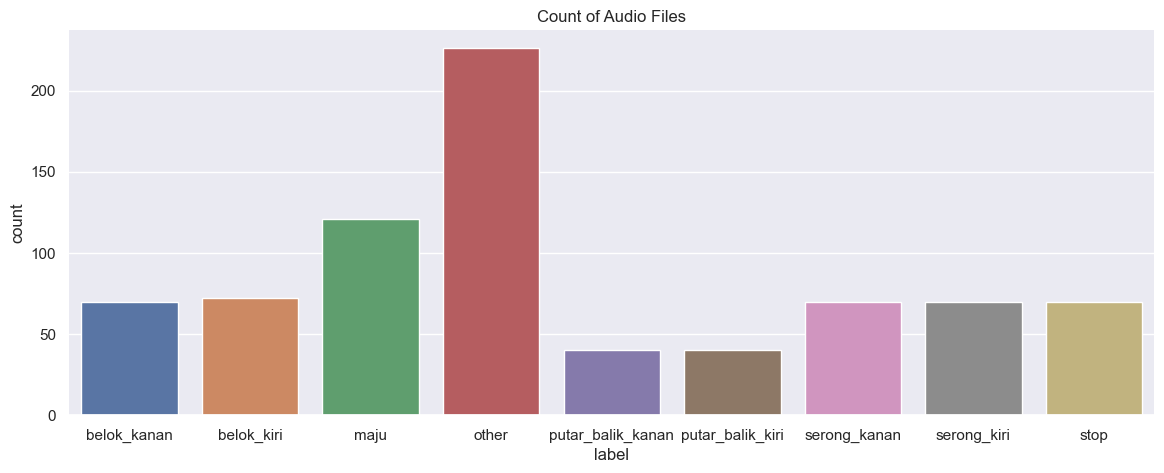

In [74]:
sns.set()
plt.figure(figsize=(14, 5))
sns.countplot(x='label', data=df)
sns.despine(top=True, right=True, left=True, bottom=False)
plt.title('Count of Audio Files')
plt.show()

In [75]:
len(df) * 0.8

623.2

In [76]:
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split as tts

all_data = belok_kanan.drop(['label'], axis=1)

X = df.drop(['label'], axis=1)

scaler = MinMaxScaler()
scaler = scaler.fit(X)
all_data = scaler.transform(all_data)

maps = {
    'maju': 0,
    'belok_kiri': 1,
    'belok_kanan': 2,
    'serong_kiri': 3,
    'serong_kanan': 4,
    'stop': 5,
    'putar_balik_kiri': 6,
    'putar_balik_kanan': 7,
    'other': 8
}

all_data_y = list(map(lambda x : maps[x], belok_kanan['label']))

X_train, X_test, y_train, y_test = tts(all_data, all_data_y, test_size=0.2)

for data in belok_kiri, maju, other, putar_balik_kanan, putar_balik_kiri, serong_kanan, serong_kiri, stop:
    X = data.drop(['label'], axis=1)
    X = scaler.transform(X)
    y = list(map(lambda x : maps[x], data['label']))
    # display(data['label'])
    xtrain, xtest, ytrain, ytest = tts(X,y, test_size=0.2)
    X_train = np.concatenate((X_train, xtrain), axis=0)
    X_test = np.concatenate((X_test, xtest), axis=0)
    y_train = np.concatenate((y_train, ytrain), axis=0)
    y_test = np.concatenate((y_test, ytest), axis=0)
# X = df.drop(['label'], axis=1)

# scaler = MinMaxScaler()
# scaler = scaler.fit(X)
# X = scaler.transform(X)

# X = np.expand_dims(X, axis=-1)

# scaler = StandardScaler()
# X = scaler.fit_transform(X)

# y = list(map(lambda x : maps[x], df['label']))

# y = pd.get_dummies(df['label']).values
# y = np.reshape(y, (len(y), 8,1))

# y = y.reshape(-1, 8)
# y = OneHotEncoder().fit_transform(df_fix['label'].values.reshape(-1, 1)).toarray()
# y = np.array(df_fix['label'].apply(lambda x : 1 if x == 'happy' else 0))

# y = np.reshape(y, (-1, 1))
# y = OneHotEncoder().fit_transform(y).toarray()


In [77]:
print(X_test.shape)

(158, 100)


In [78]:
df['label'].value_counts()

label
other                226
maju                 121
belok_kiri            72
belok_kanan           70
serong_kanan          70
serong_kiri           70
stop                  70
putar_balik_kanan     40
putar_balik_kiri      40
Name: count, dtype: int64

In [79]:
len(X_train)

621

In [80]:
from sklearn.svm import SVC
def svm_train(X_train, X_test, y_train, y_test, kernel:str='linear', C:float=1.0, gamma:str|int=None, dfs:str=None):
    svc = SVC(kernel=kernel, C=C, gamma=gamma, decision_function_shape=dfs, probability=True)
    svc.fit(X_train, y_train)
    y2 = svc.predict(X_test)
    return accuracy_score(y_test, y2)

In [81]:
def get_svm(X_train, X_test, y_train, y_test)->pd.DataFrame:
    df = pd.DataFrame(columns=['kernel', 'C', 'accuracy (%)','gamma','decision_function_shape'])
    list_gamma = [0.0001, 0.1, 1]
    list_dfs = ['ovo','ovr']
    for a in tqdm(list_dfs):
        for x in [1, 10, 100]:
            for y in ['linear', 'rbf', 'sigmoid']:
                for z in list_gamma:
                    acc = svm_train(X_train, X_test, y_train, y_test, y, x, gamma=z, dfs=a)
                    df = pd.concat([df, pd.DataFrame([{'kernel': y, 'C': x, 'accuracy (%)': acc.round(2), 'gamma': z, 'decision_function_shape':a}])], ignore_index=True)
    return df

In [82]:
get_svm_score = get_svm(X_train, X_test, y_train, y_test)

  0%|          | 0/2 [00:00<?, ?it/s]C:\Users\Windows\AppData\Local\Temp\ipykernel_29144\1507120573.py:10: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame([{'kernel': y, 'C': x, 'accuracy (%)': acc.round(2), 'gamma': z, 'decision_function_shape':a}])], ignore_index=True)
100%|██████████| 2/2 [00:06<00:00,  3.41s/it]


In [83]:
get_svm_score.sort_values(by='accuracy (%)', ascending=False)

,kernel,C,accuracy (%),gamma,decision_function_shape
14,rbf,10,0.96,1.0000,ovo
50,rbf,100,0.96,1.0000,ovr
49,rbf,100,0.96,0.1000,ovr
41,rbf,10,0.96,1.0000,ovr
22,rbf,100,0.96,0.1000,ovo
23,rbf,100,0.96,1.0000,ovo
20,linear,100,0.94,1.0000,ovo
47,linear,100,0.94,1.0000,ovr
46,linear,100,0.94,0.1000,ovr
45,linear,100,0.94,0.0001,ovr


In [84]:
get_svm_score.sort_values(by='accuracy (%)', ascending=False, inplace=True)

In [85]:
get_svm_score['rank'] = np.arange(1,len(get_svm_score)+1)

In [86]:
get_svm_score.set_index = get_svm_score['rank']

In [87]:
save_dataframe(get_svm_score, 'svm_score')

Saved as svm_score.xlsx


In [88]:
best = get_svm_score.iloc[0]

In [89]:
ticks_list = maps.keys()

In [90]:
ticks_list = list(ticks_list)
ticks_list

['maju',
 'belok_kiri',
 'belok_kanan',
 'serong_kiri',
 'serong_kanan',
 'stop',
 'putar_balik_kiri',
 'putar_balik_kanan',
 'other']

In [91]:
print(len(X_test))

158


              precision    recall  f1-score   support

           0       0.96      0.92      0.94        25
           1       0.93      0.87      0.90        15
           2       1.00      1.00      1.00        14
           3       0.86      0.86      0.86        14
           4       0.93      1.00      0.97        14
           5       1.00      1.00      1.00        14
           6       1.00      1.00      1.00         8
           7       1.00      1.00      1.00         8
           8       0.98      1.00      0.99        46

    accuracy                           0.96       158
   macro avg       0.96      0.96      0.96       158
weighted avg       0.96      0.96      0.96       158

Accuracy : 96.2%


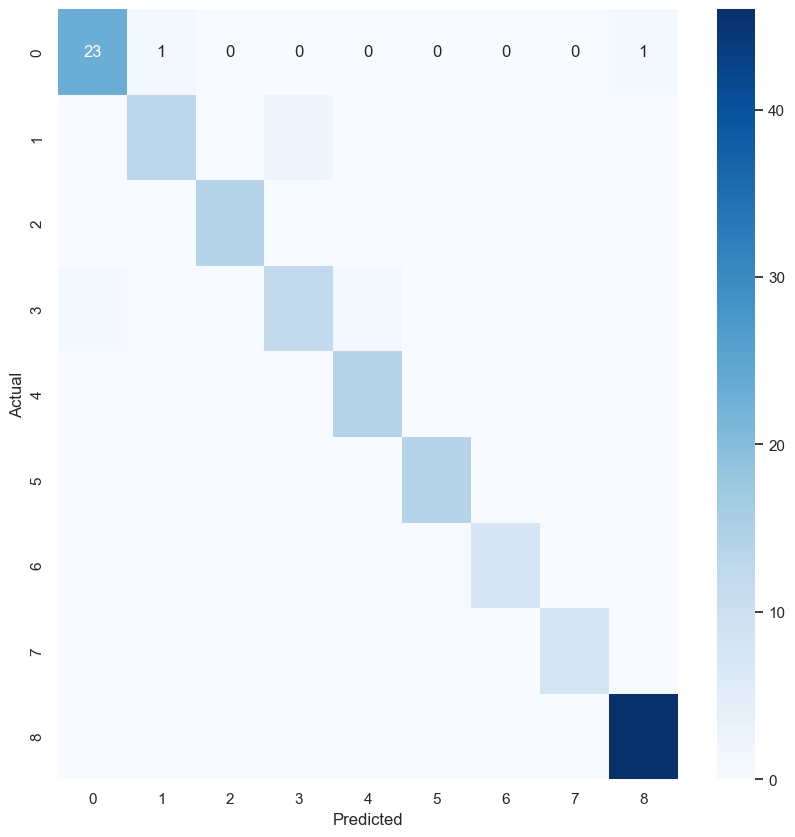

In [92]:
svm_score = SVC(kernel=best['kernel'],C=best['C'], gamma=best['gamma'], decision_function_shape=best['decision_function_shape'], probability=True)
svm_score.fit(X_train, y_train)
y_pred = svm_score.predict(X_test)
print(classification_report(y_test, y_pred))
print(f'Accuracy : {accuracy_score(y_test, y_pred).round(4)*100}%')
matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10,10))
ax = sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
# plt.xticks(np.arange(9)+0.5, ticks_list, rotation=45)
plt.ylabel('Actual')
# plt.yticks(np.arange(9)+0.5, ticks_list, rotation=45)
plt.show()

In [93]:
print(y_test, y_pred)

[2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8
 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 7 7 7 7 7 7 7 7 6 6 6
 6 6 6 6 6 4 4 4 4 4 4 4 4 4 4 4 4 4 4 3 3 3 3 3 3 3 3 3 3 3 3 3 3 5 5 5 5
 5 5 5 5 5 5 5 5 5 5] [2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 3 1 1 1 1 1 1 1 1 3 1 1 1 1 0 0 0 0 0 0 0 0
 0 8 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8
 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 7 7 7 7 7 7 7 7 6 6 6
 6 6 6 6 6 4 4 4 4 4 4 4 4 4 4 4 4 4 4 3 3 4 3 3 3 3 3 3 3 3 3 3 0 5 5 5 5
 5 5 5 5 5 5 5 5 5 5]


In [94]:
def prediction(model:object=None, df:pd.DataFrame=None):
    temp = df
    X = temp.drop(['label'], axis=1)
    # scaler = MinMaxScaler()
    X = scaler.transform(X)
    y = list(map(lambda x : maps[x], temp['label']))
    y_pred = model.predict(X)
    print(classification_report(y, y_pred))
    fig = plt.figure(figsize=(10,10))
    sns.heatmap(confusion_matrix(y, y_pred), annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.xticks(np.arange(9)+0.5, ticks_list, rotation=45)
    plt.ylabel('Actual')
    plt.yticks(np.arange(9)+0.5, ticks_list, rotation=45)
    plt.show()
    
    current_label = ''
    label_count = 0
    for i in range(len(y)):
        if current_label != temp['label'].iloc[i]:
            current_label = temp['label'].iloc[i]
            label_count = 1
        print(f'Prediction for {temp["label"].iloc[i]}_{label_count} : {y_pred[i]}')
        label_count += 1
        

In [95]:
# print(X_test)

              precision    recall  f1-score   support

           0       0.99      0.98      0.99       121
           1       0.99      0.97      0.98        72
           2       1.00      1.00      1.00        70
           3       0.97      0.97      0.97        70
           4       0.99      1.00      0.99        70
           5       1.00      1.00      1.00        70
           6       1.00      1.00      1.00        40
           7       1.00      1.00      1.00        40
           8       1.00      1.00      1.00       226

    accuracy                           0.99       779
   macro avg       0.99      0.99      0.99       779
weighted avg       0.99      0.99      0.99       779



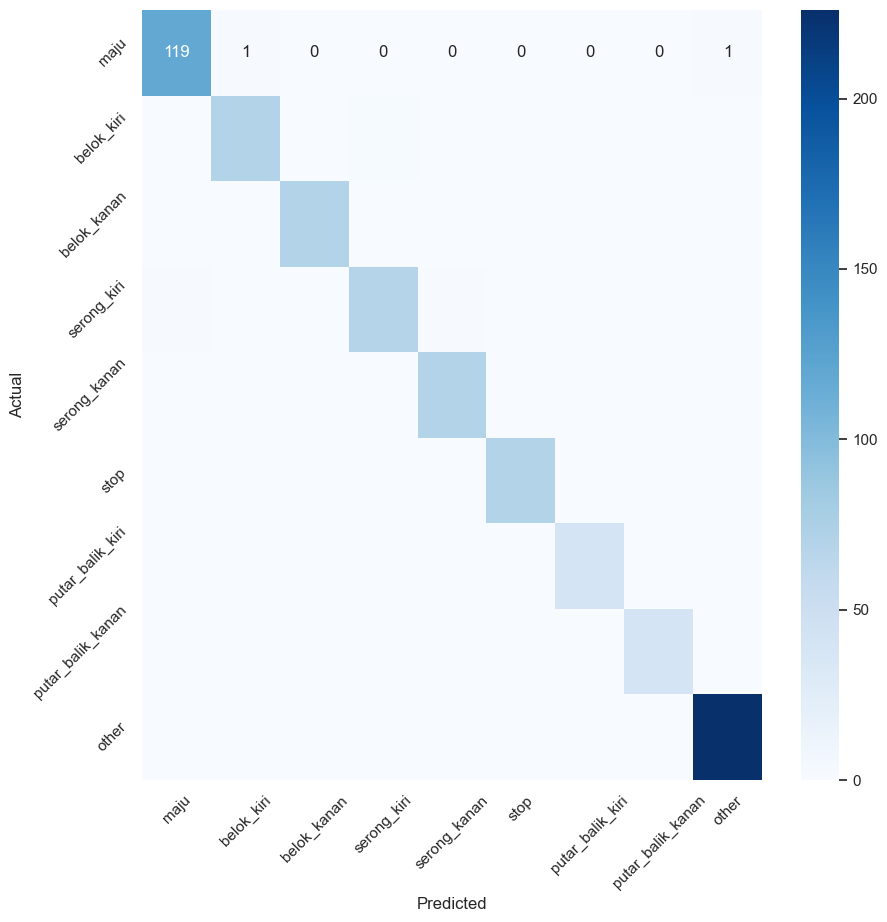

Prediction for belok_kanan_1 : 2
Prediction for belok_kanan_2 : 2
Prediction for belok_kanan_3 : 2
Prediction for belok_kanan_4 : 2
Prediction for belok_kanan_5 : 2
Prediction for belok_kanan_6 : 2
Prediction for belok_kanan_7 : 2
Prediction for belok_kanan_8 : 2
Prediction for belok_kanan_9 : 2
Prediction for belok_kanan_10 : 2
Prediction for belok_kanan_11 : 2
Prediction for belok_kanan_12 : 2
Prediction for belok_kanan_13 : 2
Prediction for belok_kanan_14 : 2
Prediction for belok_kanan_15 : 2
Prediction for belok_kanan_16 : 2
Prediction for belok_kanan_17 : 2
Prediction for belok_kanan_18 : 2
Prediction for belok_kanan_19 : 2
Prediction for belok_kanan_20 : 2
Prediction for belok_kanan_21 : 2
Prediction for belok_kanan_22 : 2
Prediction for belok_kanan_23 : 2
Prediction for belok_kanan_24 : 2
Prediction for belok_kanan_25 : 2
Prediction for belok_kanan_26 : 2
Prediction for belok_kanan_27 : 2
Prediction for belok_kanan_28 : 2
Prediction for belok_kanan_29 : 2
Prediction for belok_ka

In [96]:
prediction(svm_score, df)

In [97]:
import pickle

def save_model(model:object=None, name:str=None):
    if not os.path.exists('model'):
        os.makedirs('model')
    pickle.dump(model, open(f'{os.path.join(ROOT, "model", name)}.pkl', 'wb'))
    return print(f'Saved as {name}.pkl')

save_model(svm_score, 'svm_model_speech_recognition')

save_model(scaler, 'svm_scaler_speech_recognition')

Saved as svm_model_speech_recognition.pkl
Saved as svm_scaler_speech_recognition.pkl


In [98]:
import tensorflow
from tensorflow import keras
from tensorflow.keras import layers
import keras_tuner as kt

In [99]:
X = df.drop(['label'], axis=1)
X = scaler.transform(X)
y = list(map(lambda x : maps[x], df['label']))
y = np.reshape(y, (-1, 1))

X_train, X_test, y_train, y_test = tts(X, y, test_size=0.2)

In [100]:
def build_model(hp):
    model = keras.Sequential()
    model.add(layers.InputLayer(input_shape=(X_train.shape[1],1)))
    model.add(layers.Conv1D(filters=hp.Choice('filters', [16,32,64])
                                             ,kernel_size=3
                                             ,activation='relu'
                                             ,kernel_initializer='he_normal'
                                             ,padding='same'))
    model.add(layers.MaxPooling1D(3, padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.Flatten())
    for i in range(hp.Int('num_layers', 3, 6)):
        model.add(layers.Dense(units=hp.Int('units_' + str(i), min_value=32, max_value=512, step=32), activation='relu'))
        model.add(layers.BatchNormalization())

    model.add(layers.Dense(9, activation='sigmoid'))
    model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model

In [101]:
tuner = kt.Hyperband(hypermodel=build_model,
                     objective='val_accuracy',
                     max_epochs=100,
                     factor=3,
                     hyperband_iterations=3,
                     seed=42,
                     overwrite=True)

In [102]:
tuner.search(x=X_train,
             y=y_train,
             validation_split=0.2,
             callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)], 
             epochs=30         
            )

Trial 69 Complete [00h 00m 03s]
val_accuracy: 0.31200000643730164

Best val_accuracy So Far: 0.4320000112056732
Total elapsed time: 00h 03m 28s

Search: Running Trial #70

Value             |Best Value So Far |Hyperparameter
64                |16                |filters
5                 |4                 |num_layers
192               |96                |units_0
192               |416               |units_1
32                |256               |units_2
0.01              |0.001             |learning_rate
384               |384               |units_3
352               |352               |units_4
448               |64                |units_5
2                 |2                 |tuner/epochs
0                 |0                 |tuner/initial_epoch
4                 |4                 |tuner/bracket
0                 |0                 |tuner/round

Epoch 1/2
12/16 [=====================>........] - ETA: 0s - loss: 2.6981 - accuracy: 0.4010

KeyboardInterrupt: 

In [ ]:
best_hp = tuner.get_best_hyperparameters()[0]
final_model = tuner.hypermodel.build(best_hp)

final_model_history = final_model.fit(x=X_train,
                                      y=y_train,
                                      validation_split=0.2,
                                      callbacks=[keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)],
                                      epochs=50)

Epoch 1/50
16/16 [==============================] - 2s 19ms/step - loss: 1.3342 - accuracy: 0.5783 - val_loss: 2.1617 - val_accuracy: 0.2800
Epoch 2/50
16/16 [==============================] - 0s 9ms/step - loss: 0.5192 - accuracy: 0.8213 - val_loss: 2.1557 - val_accuracy: 0.2160
Epoch 3/50
16/16 [==============================] - 0s 9ms/step - loss: 0.2831 - accuracy: 0.9076 - val_loss: 2.0678 - val_accuracy: 0.2080
Epoch 4/50
16/16 [==============================] - 0s 9ms/step - loss: 0.1641 - accuracy: 0.9558 - val_loss: 2.0231 - val_accuracy: 0.2000
Epoch 5/50
16/16 [==============================] - 0s 9ms/step - loss: 0.1374 - accuracy: 0.9739 - val_loss: 1.9829 - val_accuracy: 0.2160
Epoch 6/50
16/16 [==============================] - 0s 9ms/step - loss: 0.1112 - accuracy: 0.9659 - val_loss: 1.9148 - val_accuracy: 0.2880
Epoch 7/50
16/16 [==============================] - 0s 9ms/step - loss: 0.0780 - accuracy: 0.9759 - val_loss: 1.8601 - val_accuracy: 0.4400
Epoch 8/50
16/16 [=

In [ ]:
save_model(final_model, 'cnn_model_speech_recognition')

Saved as cnn_model_speech_recognition.pkl
